**Mass Search**


Алфавит данных Σ

Буфер поиска Н длинной |Н| = h

множество подстрок для поиска {N} количеством |N| = n

max|N| < h
|Σ| = 256


In [4]:
import math
import time
import numpy as np
from matplotlib import pyplot as plt
from numba import cuda


Реализация алгоритма на CPU и далее на GPU

In [2]:
# Функция для поиска на CPU
# R - матрица
# N - множество подстрок поиска
# Н - буфер поиска
def mass_search_CPU(R, N, H):
    for j in range(R.shape[1]):
        for i in range(R.shape[0]):
            n = N[i]
            for k in range(len(n)):
                if n[k] in H[j]:
                    R[i, j - k] -= 1
    return R



# Функция для поиска на GPU
@cuda.jit
def mass_search_GPU(R, N, H):
    # Пропишем работу с сеткой и нитями в более явном виде
    for j in range(cuda.grid(2)[1], R.shape[1], cuda.blockDim.y * cuda.gridDim.y):
        for i in range(cuda.grid(2)[0], R.shape[0], cuda.blockDim.x * cuda.gridDim.x):
          if i < R.shape[0] and j < R.shape[1]:
              n = N[i]
              for k in range(len(n)):
                  for x in range(len(H[j])):
                      if n[k] == H[j][x]:
                          R[i, j - k] -= 1


Функции сохранения данных в csv файл и функции запуска процесса массового поиска подстрок

In [5]:
import csv
# Функция для сохраения полученных результатов в CSV файл
def save_array_to_csv(my_array, filename):
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerows(my_array)


def mass_search_calculation(sizes: np.ndarray):
    values_CPU = np.zeros((0, dims.shape[0]))
    values_GPU = np.zeros((0, dims.shape[0]))

    for n in range(15):
        time_CPU = []
        time_GPU = []

        for dim in dims:
            str_size = 2
            # Генерация случайных данных в
            R = np.zeros((dim, str_size), dtype=int)
            N = np.random.randint(len(ABC), size=(dim, str_size), dtype=np.uint8)
            H = np.random.randint(len(ABC), size=(dim, str_size), dtype=np.uint8)

            # Измерение времени выполнения на CPU
            start_CPU = time.time()
            mass_search_CPU(R, N, H)
            end_CPU = time.time() - start_CPU
            time_CPU.append(end_CPU)

            # Измерение времени выполнения на GPU
            start_GPU = time.time()
            R_cuda = cuda.to_device(R)
            N_cuda = cuda.to_device(N)
            H_cuda = cuda.to_device(H)

            mass_search_GPU[blocks_per_grid, threads_per_block](R_cuda, N_cuda, H_cuda)

            # Синхронизация

            cuda.synchronize()
            R_cuda.copy_to_host(R)

            end_GPU = time.time() - start_GPU
            time_GPU.append(end_GPU)
            save_array_to_csv(R, f"GPU_{dim}")

        # Группируем результаты поиска алгоритмов на  CPU и GPU и время их выполнения в таблицу
        values_CPU = np.vstack((values_CPU, np.array(time_CPU).reshape((1, 10))))
        values_GPU = np.vstack((values_GPU, np.array(time_GPU).reshape((1, 10))))

    values_CPU = np.squeeze(values_CPU)
    values_GPU = np.squeeze(values_GPU)

    # Вычисление среднего времени работы алгоритма для каждого размера данных
    mass_CPU_time = [np.mean(values_CPU[:, i]) for i in range(values_CPU.shape[1])]
    mass_GPU_time = [np.mean(values_GPU[:, i]) for i in range(values_GPU.shape[1])]

    return mass_CPU_time, mass_GPU_time


Получение результатов и проецирование их в табличной и графической форме

  Vector size    CPU time in sec.    GPU time in sec.    Ускорение GPU отнисительно CPU
-------------  ------------------  ------------------  --------------------------------
          160          0.00474513          0.00191628                           2.47622
          320          0.00956699          0.00284562                           3.362
          480          0.014073            0.00186532                           7.54456
          640          0.0178089           0.00236654                           7.52528
          800          0.0224056           0.00178846                          12.5279
          960          0.0242241           0.00188467                          12.8532
         1120          0.0264274           0.00225422                          11.7236
         1280          0.0308702           0.00225499                          13.6897
         1440          0.0358185           0.00213149                          16.8044
         1600          0.0472982       

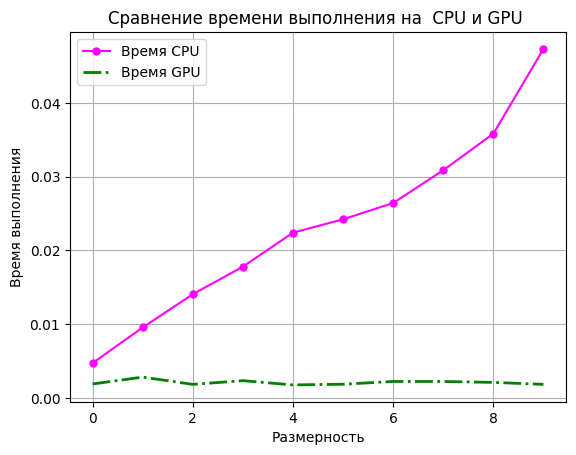

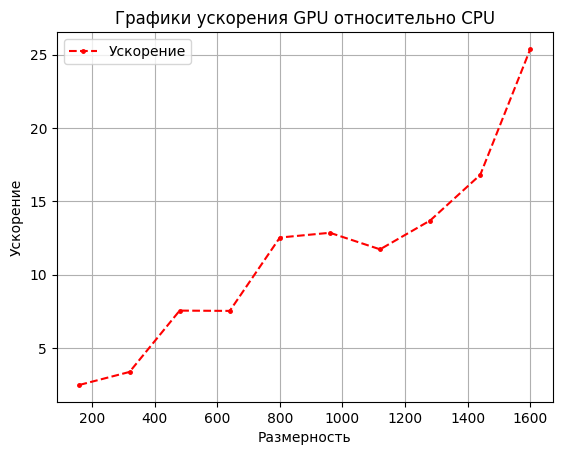

In [15]:
from tabulate import tabulate

if __name__ == "__main__":

    threads_per_block = (8, 8)

    # Размерности данных
    dims = np.linspace(160, 1600, 10, dtype=int)

    blocks_per_grid = math.ceil(dims[0]/threads_per_block[0]), math.ceil(dims[1]/threads_per_block[1])

    # Восьмибитный алфавит |Σ| = 256
    ABC = np.arange(256)

    mass_CPU_time, mass_GPU_time = mass_search_calculation(dims)
    mass_CPU_time = np.array(mass_CPU_time)
    mass_GPU_time = np.array(mass_GPU_time)


    results = {'Vector size': dims,'CPU time in sec.':mass_CPU_time, 'GPU time in sec.': mass_GPU_time, 'Ускорение GPU отнисительно CPU': mass_CPU_time / mass_GPU_time}

    print(tabulate(results, headers="keys"))


    # График изменения скорости
    plt.grid()
    plt.plot(mass_CPU_time , label='Время CPU', color ='magenta', marker ='o', markersize = 5)
    plt.plot(mass_GPU_time, label='Время GPU', color='green', linestyle='dashdot', linewidth=2 )
    plt.title('Сравнение времени выполнения на  CPU и GPU ')
    plt.xlabel('Размерность')
    plt.ylabel('Время выполнения')
    plt.legend()
    plt.show()

    # Построение графика ускорения
    plt.grid()
    plt.plot(dims, mass_CPU_time / mass_GPU_time, label='Ускорение', linestyle='dashed', marker = '.', color = 'red', markersize = 5)

    plt.title('Графики ускорения GPU относительно CPU')
    plt.xlabel('Размерность')
    plt.ylabel('Ускорение')
    plt.legend()
    plt.show()